In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
#Transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))])
trainset = datasets.FashionMNIST('Fashion_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('Fashion_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([64, 1, 28, 28])

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        #Add dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.resize_(images.shape[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images = images.resize_(images.shape[0], 784)
                log_ps = model.forward(images)
                test_loss += criterion(log_ps, labels) 
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training Loss: {:.3f}".format(running_loss/len(trainloader)),
              "Testing Loss: {:.3f}".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30... Training Loss: 0.602 Testing Loss: 0.470 Test Accuracy: 0.830
Epoch: 2/30... Training Loss: 0.480 Testing Loss: 0.448 Test Accuracy: 0.835
Epoch: 3/30... Training Loss: 0.449 Testing Loss: 0.428 Test Accuracy: 0.849
Epoch: 4/30... Training Loss: 0.432 Testing Loss: 0.406 Test Accuracy: 0.855
Epoch: 5/30... Training Loss: 0.419 Testing Loss: 0.432 Test Accuracy: 0.845
Epoch: 6/30... Training Loss: 0.418 Testing Loss: 0.404 Test Accuracy: 0.859
Epoch: 7/30... Training Loss: 0.401 Testing Loss: 0.394 Test Accuracy: 0.859
Epoch: 8/30... Training Loss: 0.394 Testing Loss: 0.407 Test Accuracy: 0.857
Epoch: 9/30... Training Loss: 0.391 Testing Loss: 0.429 Test Accuracy: 0.862
Epoch: 10/30... Training Loss: 0.383 Testing Loss: 0.392 Test Accuracy: 0.867
Epoch: 11/30... Training Loss: 0.385 Testing Loss: 0.394 Test Accuracy: 0.864
Epoch: 12/30... Training Loss: 0.380 Testing Loss: 0.379 Test Accuracy: 0.865
Epoch: 13/30... Training Loss: 0.370 Testing Loss: 0.379 Test Accuracy: 0

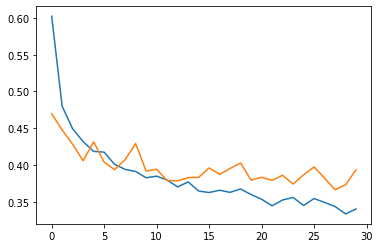

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')

In [13]:
print("Our model:\n\n" , model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model:

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [14]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [11]:
import numpy as np
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

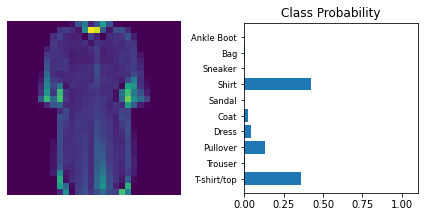

In [12]:
import torch.nn.functional as F
images, labels = next(iter(testloader))
img = images[0].resize(1, 784)
with torch.no_grad():
    logits = model.forward(img)
ps = F.softmax(logits, dim=1)
view_classify(img.view(1,28,28), ps, version='Fashion')